In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 160000  #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [0]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
      list_item=[row[5],int(int(row[1])>0) ]
      num_sentences = num_sentences + 1
      corpus.append(list_item)


--2020-05-13 02:08:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   205MB/s    in 1.1s    

2020-05-13 02:08:03 (205 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 1]


In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length ,padding = 'post', truncating = 'post')

split = int(test_portion * training_size)

print(padded.shape)

test_sequences = padded[-split:]
training_sequences = padded[:-split]
test_labels = labels[-split:]
training_labels = labels[:-split]
print(training_sequences.shape)

(160000, 16)
(144000, 16)


In [0]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138647
2


In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-13 02:08:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   162MB/s    in 2.0s    

2020-05-13 02:08:21 (162 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138648


In [0]:
from tensorflow.keras.layers import Embedding, Dense, Conv1D, LSTM, Bidirectional, GRU, BatchNormalization

model = tf.keras.Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dense(32, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')

])
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13864800  
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [0]:

num_epochs = 50
history = model.fit(training_sequences, np.array(training_labels),
                    epochs=num_epochs, 
                    validation_data=(test_sequences, np.array(test_labels)), 
                    verbose=1)

print("Training Complete")


Epoch 1/50
4500/4500 [==============================] - 42s 9ms/step - loss: 0.0216 - accuracy: 0.9959 - val_loss: 7.9911e-05 - val_accuracy: 1.0000
Epoch 2/50
4500/4500 [==============================] - 40s 9ms/step - loss: 2.6727e-05 - accuracy: 1.0000 - val_loss: 5.2401e-06 - val_accuracy: 1.0000
Epoch 3/50
4500/4500 [==============================] - 40s 9ms/step - loss: 1.9535e-06 - accuracy: 1.0000 - val_loss: 4.3609e-07 - val_accuracy: 1.0000
Epoch 4/50
4500/4500 [==============================] - 41s 9ms/step - loss: 1.6684e-07 - accuracy: 1.0000 - val_loss: 3.6791e-08 - val_accuracy: 1.0000
Epoch 5/50
4500/4500 [==============================] - 40s 9ms/step - loss: 2.3548e-08 - accuracy: 1.0000 - val_loss: 1.9437e-08 - val_accuracy: 1.0000
Epoch 6/50
4500/4500 [==============================] - 40s 9ms/step - loss: 1.8524e-08 - accuracy: 1.0000 - val_loss: 1.7132e-08 - val_accuracy: 1.0000
Epoch 7/50
4500/4500 [==============================] - 41s 9ms/step - loss: 1.6888e-0

<Figure size 432x288 with 0 Axes>

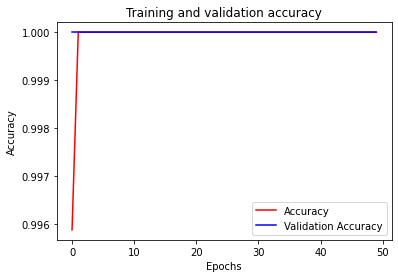

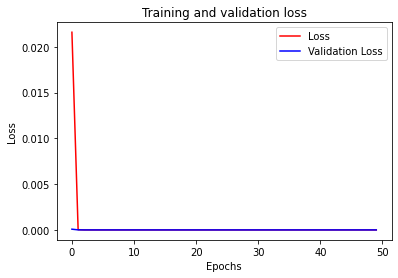

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!